A toy variational quantum algorithm defined in Tierkreis. See the paper for more
details: [Tierkreis: a Dataflow Framework for
Hybrid Quantum-Classical Computing](https://arxiv.org/abs/2211.02350)


You will need tierkreis and pytket-qiskit installed for this:

In [ ]:
%pip install tierkreis[typecheck,commontypes]==0.1.0 pytket-qiskit==0.24
# remove typecheck if it is not supported on your system

In [1]:
import json
from tierkreis.builder import (
    Output,
    IfElse,
    If,
    Else,
    Const,
    loop,
    Box,
    graph,
    closure,
    Input,
    Continue,
    Break,
    Copyable,
    Namespace,
)

from tierkreis.pyruntime import PyRuntime
import sys
from pytket import Circuit
from sympy import symbols


First we set up our `PyRuntime` client with the namespaces we need (some have to
be appended to the path, make sure you run this notebook from the `examples`
directory, or adjust `_TK_ROOT_DIR` accordingly).

In [2]:
from pathlib import Path

_TK_ROOT_DIR = Path("..")
sys.path.append(str(_TK_ROOT_DIR / "tests/"))
sys.path.append(str(_TK_ROOT_DIR / "pytket_worker/"))
import test_worker.main
import pytket_worker.main

# sc22_worker is already in same directory
import sc22_worker.main

cl = PyRuntime([test_worker.main.root, pytket_worker.main.root, sc22_worker.main.root])

sig = await cl.get_signature()
bi = Namespace(sig)
pt = bi["pytket"]
pn = bi["python_nodes"]
sc = bi["sc22"]


We now define a parametrized [pytket](https://github.com/CQCL/tket) circuit
with two parameters _a_ and _b_ which we will optimise according to some cost function.

In [3]:
from pytket.circuit.display import render_circuit_jupyter

# Define a simple parametrized pytket circuit
a, b = symbols("a b")
ansatz = Circuit(2)
ansatz.Rx(0.5 + a, 0).Rx(-0.5 + b, 1).CZ(0, 1).Rx(0.5 + b, 0).Rx(-0.5 + a, 1)
ansatz.measure_all()


render_circuit_jupyter(ansatz)


Next, a graph to store this circuit and output it as a Tierkreis value to
be used later, and a simple utility graph.

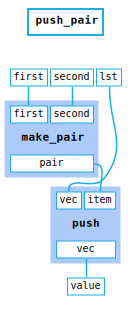

In [4]:
@graph()
def load_circuit() -> Output:
    js_str = json.dumps(ansatz.to_dict())
    c = pt.load_circuit_json(Const(js_str))
    return Output(c)


# a simple utility graph to push a pair on to a list
@graph()
def push_pair(lst, first, second) -> Output:
    pair = bi.make_pair(first, second)
    return Output(bi.push(lst, pair))


# put graph in a box for later use
push_pair_box = Box(push_pair())

push_pair()


Now we can define a graph to generate the initial value for our optimisation
loop. In our variational experiment, at each iteration we will execute the
circuit with a set of parameters, calculate the cost function from the results,
and append both parameters and cost to a vector. This `initial` function
prepares the first value of the vector, given a graph `run` with which to
evaluate the cost for some parameters.

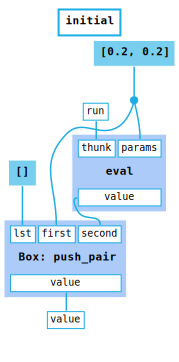

In [5]:
# Generate an initial value for the optimisation
@graph()
def initial(run) -> Output:
    init_params = Copyable(Const([0.2, 0.2]))
    init_score = bi.eval(run, params=init_params)
    return Output(push_pair_box(Const([]), init_params, init_score))


init_box = Box(initial())
initial()


Our cost function for the minimisation is the expectation value of the parity
operator _p_, we can calculate this from the expectation value _z_ of the all _Z_
operator using the function $p = (1 - z)/2$. The following graph calculates this
function on floating point values.

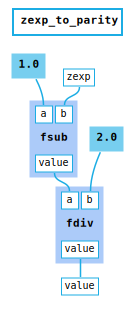

In [6]:
@graph()
def zexp_to_parity(zexp) -> Output:
    y = bi.fsub(Const(1.0), zexp)
    return Output(bi.fdiv(y, Const(2.0)))


zexp_to_parity()


We are now ready to define our main graph. First we have to define a graph for
running the circuit and calculating the cost function, this is defined as the
_closure_ `run_circuit`.
This is used in the main optimisation loop, the body of which is defined in the
`loop_def` function; at each iteration the worker function
`new_params` produces updated parameters, then convergence is checked using
`converged`, at which point we either conditionally `Break` with the result or `Continue`.

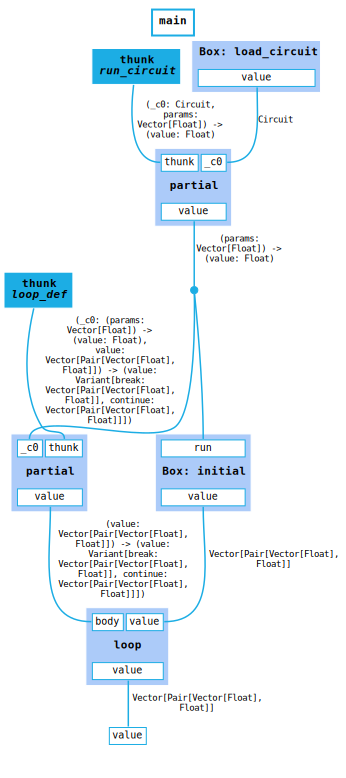

In [7]:
# if you don't have the typecheck feature installed, remove the type_check_sig parameter
@graph(type_check_sig=sig)
def main() -> Output:
    circ = Box(load_circuit())()

    @closure()
    def run_circuit(params: Input) -> Output:
        syms = Const(["a", "b"])
        # substitute parameters in circuit with values a, b
        subs = pt.substitute_symbols(circ, syms, params)
        res = pt.execute(subs, Const(1000), Const("AerBackend"))
        o = Output(Box(zexp_to_parity())(pt.z_expectation(res)))
        return o

    run_circuit.copyable()

    @loop()
    def loop_def(initial: Input) -> Output:
        recs = Copyable(initial)
        new_cand = Copyable(sc.new_params(recs))
        score = run_circuit(new_cand)
        recs = Copyable(push_pair_box(recs, new_cand, score))

        with IfElse(sc.converged(recs)) as lbody:
            with If():
                Break(recs)
            with Else():
                Continue(recs)
        o = Output(lbody.nref)
        return o

    init_val = init_box(run_circuit.graph_src)
    # run loop with initial value
    return Output(loop_def(init_val))


tg = main()
tg


We are now ready to run the graph and check the results!

In [8]:
res = await cl.run_graph(tg)

# print final parameters and score
res["value"].try_autopython()[-1]


([0.5104587283740356, 0.5104587283740356], 0.0010000000000000009)

To view the graph in more detail we can use the `tierkreis_to_graphviz` with
`unbox_level` > 0, and `unbox_graph_names` to say which subgraphs we want displayed:

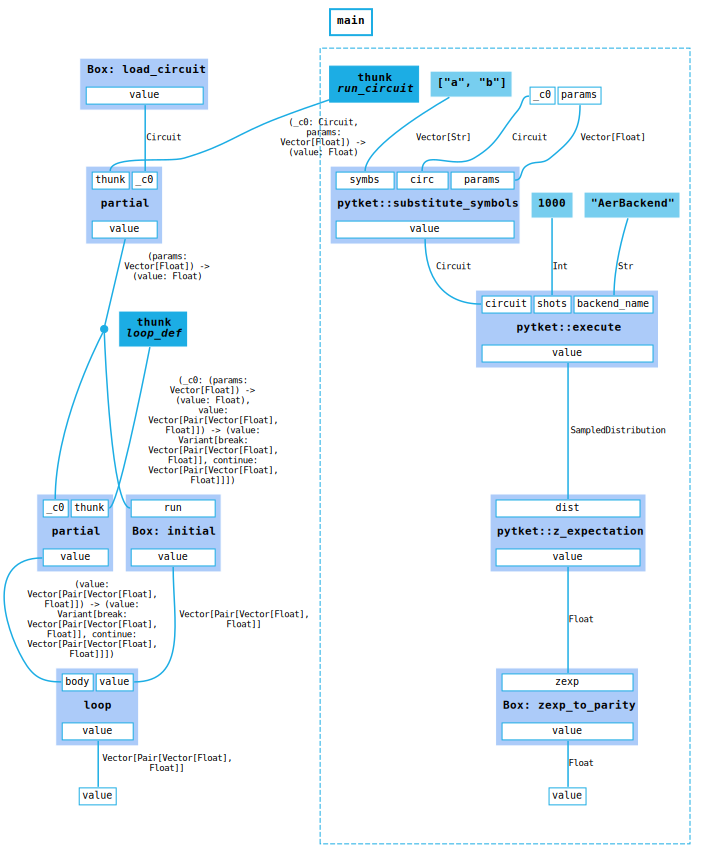

In [9]:
from tierkreis import tierkreis_to_graphviz

tierkreis_to_graphviz(tg, unbox_graph_names={"run_circuit"}, unbox_level=1)